In [1]:
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 1.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy.fftpack import dct
from matplotlib import pyplot as plt
import os
import soundfile as sf
import torch
import pickle
import librosa
import time
import gc
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn import preprocessing
import collections
from torch import Tensor
import torch.nn as nn
import sys
from torchvision import transforms
from torchsummary import summary
from sklearn.metrics import confusion_matrix

from tensorboardX import SummaryWriter

from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve

from joblib import Parallel, delayed
import pdb

In [6]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
! pip install samplerate

In [7]:
#%cd drive/My\ Drive/FYP/
%cd /content/drive/My\ Drive/FYP/ASVSpoof_2019/Test

/content/drive/My Drive/FYP/ASVSpoof_2019/Test


## Dataset Loader

In [ ]:
ASVFile = collections.namedtuple('ASVFile',
    ['speaker_id', 'file_name', 'path', 'sys_id', 'key'])

class ASVDataset(Dataset):
  def __init__(self, feats_file, transform = None, is_eval = False, is_train = False):
    self.sysid_dict = {
            '-': 0,  # bonafide speech
            'A01': 1, # neural waveform model
            'A02': 2, # vocoder
            'A03': 3, # vocoder
            'A04': 4, # waveform concatenation
            'A05': 5, # vocoder
            'A06': 6, # spectral filtering
            'A07': 7, # vocoder+GAN
            'A08': 8, # neural waveform
            'A09': 9, # vocoder
            'A10': 10, # neural waveform
            'A11': 11, # griffin lim
            'A12': 12, # neural waveform
            'A13': 13, # waveform concatenation+waveform filtering
            'A14': 14, # vocoder
            'A15': 15, # neural waveform
            'A16': 16, # waveform concatenation
            'A17': 17, # waveform filtering
            'A18': 18, # vocoder
            'A19': 19, # spectral filtering
            # For PA:
            'AA':20,
            'AB':21,
            'AC':22,
            'BA':23,
            'BB':24,
            'BC':25,
            'CA':26,
            'CB':27,
            'CC': 28
    }
    self.sysid_dict_inv = {v:k for k,v in self.sysid_dict.items()}
    with open(feats_file, 'rb') as infile:
        self.dataset = pickle.load(infile)
    #self.dataset = torch.load(feats_file)
    self.dataset['label'] = self.dataset['label'].replace(['bonafide','LA_spoof', 'PA_spoof'],[0, 1, 2])
    self.data_x = self.dataset['data_x']
    self.data_y = self.dataset['label'].to_numpy()
    self.data_y = self.data_y.reshape(len(self.data_y), 1)
    self.transform = transform
    if self.transform:
        # self.data_x = list(map(self.transform, self.data_x))
        self.data_x = Parallel(n_jobs=1, prefer='threads')(delayed(self.transform)(x) for x in self.data_x)
    self.labels = self.dataset['label']
    self.is_eval = is_eval
    self.is_train = is_train
    self.protocols_fname = 'eval.trl' if is_eval else 'train.trn' if is_train else 'dev.trl'
    self.protocols_fname = os.path.join('CM_protocol','cm_{}.txt'.format(self.protocols_fname))
    self.dset_name = 'Eval' if is_eval else 'Train' if is_train else 'Dev'
    self.files_dir = os.path.join(self.dset_name, "flac")
    self.files_meta = self.parse_protocols_file(self.protocols_fname)

  def __len__(self):
    return len(self.data_x)

  def __getitem__(self, idx):
    x = self.data_x[idx]
    label = float(self.data_y[idx])
    return x, label, self.files_meta[idx]

  def _parse_line(self, line):
    tokens = line.strip().split(' ')
    if tokens[4] == 'bonafide':
      label_y = 0
    elif tokens[4] == 'LA_spoof':
      label_y = 1
    else:
      label_y = 2
    return ASVFile(speaker_id=tokens[0],
        file_name=tokens[1],
        path=os.path.join(self.files_dir, tokens[1] + '.flac'),
        sys_id=self.sysid_dict[tokens[3]],
        key=label_y)

  def parse_protocols_file(self, protocols_fname):
      lines = open(protocols_fname).readlines()
      files_meta = map(self._parse_line, lines)
      return list(files_meta)

## DL Model

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_depth, depth, first=False):
        super(ResNetBlock, self).__init__()
        self.first = first
        self.conv1 = nn.Conv2d(in_depth, depth, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(depth)
        self.lrelu = nn.LeakyReLU(0.01)
        self.dropout = nn.Dropout(0.5)
        self.conv2 = nn.Conv2d(depth, depth, kernel_size=3, stride=3, padding=1)
        self.conv11 = nn.Conv2d(in_depth, depth, kernel_size=3, stride=3, padding=1)
        if not self.first :
            self.pre_bn = nn.BatchNorm2d(in_depth)

    def forward(self, x):
        # x is (B x d_in x T)
        prev = x
        prev_mp =  self.conv11(x)
        if not self.first:
            out = self.pre_bn(x)
            out = self.lrelu(out)
        else:
            out = x
        out = self.conv1(x)
        # out is (B x depth x T/2)
        out = self.bn1(out)
        out = self.lrelu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        # out is (B x depth x T/2)
        out = out + prev_mp
        return out

class CQCCModel(nn.Module):
    def __init__(self):
        super(CQCCModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.block1 = ResNetBlock(32, 32, True)
        self.mp = nn.MaxPool2d(3, stride=3, padding=1)
        self.block2 = ResNetBlock(32, 32, False)
        self.block3 = ResNetBlock(32, 32, False)
        self.block4 = ResNetBlock(32, 32, False)
        self.block5 = ResNetBlock(32, 32, False)
        self.block6 = ResNetBlock(32, 32, False)
        self.block7 = ResNetBlock(32, 32, False)
        self.block8 = ResNetBlock(32, 32, False)
        self.block9 = ResNetBlock(32, 32, False)
        self.block10 = ResNetBlock(32, 32, False)
        self.block11 = ResNetBlock(32, 32, False)
        self.lrelu = nn.LeakyReLU(0.01)
        self.bn = nn.BatchNorm2d(32)
        self.dropout = nn.Dropout(0.5)
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.fc1 = nn.Linear(32, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.unsqueeze(dim=1)
        out = self.conv1(x)
        out = self.block1(out)
        # out = self.block2(out)
        # out = self.mp(out)
        out = self.block3(out)
        # out = self.block4(out)
        out = self.mp(out)
        out = self.block5(out)
        # out = self.block6(out)
        out = self.mp(out)
        out = self.block7(out)
        # out = self.block8(out)
        out = self.mp(out)
        out = self.block9(out)
        # out = self.block10(out)
        out = self.mp(out)
        out = self.block11(out)
        out = self.bn(out)
        out = self.lrelu(out)
        out = self.mp(out)
        out = out.view(batch_size, -1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.lrelu(out)
        out = self.fc2(out)
        out = self.logsoftmax(out)
        return out

## Training

In [ ]:
def train_epoch(data_loader, model, lr, device):
    running_loss = 0
    num_correct = 0.0
    num_total = 0.0
    ii = 0
    model.train()
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    weight = torch.FloatTensor([1.0, 5.0, 9.0]).to(device)
    criterion = nn.NLLLoss(weight=weight)
    for batch_x, batch_y, batch_meta in data_loader:
        batch_size = batch_x.size(0)
        num_total += batch_size
        ii += 1
        batch_x = batch_x.to(device)
        #pdb.set_trace()
        batch_y = batch_y.view(-1).type(torch.int64).to(device)
        #pdb.set_trace()
        batch_out = model(batch_x)
        #pdb.set_trace()
        batch_loss = criterion(batch_out, batch_y)
        _, batch_pred = batch_out.max(dim=1)
        num_correct += (batch_pred == batch_y).sum(dim=0).item()
        running_loss += (batch_loss.item() * batch_size)
        if ii % 10 == 0:
            sys.stdout.write('\r \t {:.2f}'.format(
                (num_correct/num_total)*100))
        optim.zero_grad()
        batch_loss.backward()
        optim.step()
    running_loss /= num_total
    train_accuracy = (num_correct/num_total)*100
    return running_loss, train_accuracy

def evaluate_accuracy(data_loader, model, device):
    num_correct = 0.0
    num_total = 0.0
    model.eval()
    for batch_x, batch_y, batch_meta in data_loader:
        batch_size = batch_x.size(0)
        num_total += batch_size
        batch_x = batch_x.to(device)
        batch_y = batch_y.view(-1).type(torch.int64).to(device)
        batch_out = model(batch_x)
        _, batch_pred = batch_out.max(dim=1)
        num_correct += (batch_pred == batch_y).sum(dim=0).item()
    return 100 * (num_correct / num_total)

tran = transforms.Compose([
        lambda x: Tensor(x)
          ])

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
dev_set_path = os.getcwd() + "/cqcc_feats_dev"
train_set_path = os.getcwd() + "/cqcc_feats_train"
eval_set_path = os.getcwd() + "/cqcc_feats_eval"

In [ ]:
model = CQCCModel().to(device)

# Model Training

In [ ]:
batch_size = 32
num_epochs = 100
lr = 0.0001
model_tag = 'model_{}_{}_{}_{}'.format('CQCC', num_epochs, batch_size, lr)
model_save_path = os.path.join('models', model_tag)

model = CQCCModel().to(device)

if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

dev_set = ASVDataset(dev_set_path, is_train=False, is_eval= False, transform = tran)

dev_loader = DataLoader(dev_set, batch_size=batch_size, shuffle=True)

train_set = ASVDataset(train_set_path, is_train=True, transform = tran)

train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

writer = SummaryWriter('logs/{}'.format(model_tag))


In [ ]:
for epoch in range(num_epochs):
    running_loss, train_accuracy = train_epoch(
         train_loader, model, lr, device)
    valid_accuracy = evaluate_accuracy(dev_loader, model, device)
    writer.add_scalar('train_accuracy', train_accuracy, epoch)
    writer.add_scalar('valid_accuracy', valid_accuracy, epoch)
    writer.add_scalar('loss', running_loss, epoch)
    print('\n{} - {} - {:.2f} - {:.2f}'.format(epoch,
                                                running_loss, train_accuracy, valid_accuracy))
    torch.save(model.state_dict(), os.path.join(
        model_save_path, 'epoch_{}.pth'.format(epoch)))

 	 65.46
0 - 0.8615317337155206 - 65.71 - 79.18
 	 80.41
1 - 0.4742388218675419 - 80.44 - 81.12
 	 81.30
2 - 0.3681757858733541 - 81.36 - 79.63
 	 81.98
3 - 0.34175630430994985 - 81.97 - 81.45
 	 82.10
4 - 0.3409140512728427 - 82.07 - 81.33
 	 82.46
5 - 0.3327351108039777 - 82.46 - 81.80
 	 82.51
6 - 0.32928082993259045 - 82.50 - 81.74
 	 82.36
7 - 0.32670026374095357 - 82.38 - 81.71
 	 82.41
8 - 0.3254360457033818 - 82.46 - 81.92
 	 82.36
9 - 0.32243630511927307 - 82.33 - 81.76
 	 82.80
10 - 0.3181682801647194 - 82.83 - 81.33
 	 83.10
11 - 0.3139132685097359 - 82.95 - 81.76
 	 82.82
12 - 0.3138846988359814 - 82.79 - 81.92
 	 82.74
13 - 0.3101468944979697 - 82.83 - 82.01
 	 83.17
14 - 0.3083312288524086 - 83.09 - 80.45
 	 82.98
15 - 0.30712217610840037 - 83.06 - 81.45
 	 82.85
16 - 0.3076077753257642 - 82.88 - 82.18
 	 82.87
17 - 0.2983167977586144 - 82.88 - 82.14
 	 82.91
18 - 0.3016451982743597 - 83.02 - 74.87
 	 83.36
19 - 0.2932025738097457 - 83.38 - 82.29
 	 83.11
20 - 0.295624247

## Evaluation

In [ ]:
model_path = os.getcwd() + "/models/model_CQCC_100_32_0.0001/epoch_99.pth"

model.load_state_dict(torch.load(model_path, map_location ='cpu'))
print('Model loaded : {}'.format(model_path))

Model loaded : /content/drive/My Drive/FYP/ASVSpoof_2019/Test/models/model_CQCC_100_32_0.0001/epoch_99.pth


In [ ]:
batch_size = 32
eval_set = ASVDataset(eval_set_path, is_train=False, is_eval= True, transform = tran)
eval_loader = DataLoader(eval_set, batch_size=batch_size, shuffle=True)


#### Accuracy

In [ ]:
valid_accuracy = evaluate_accuracy(eval_loader, model, device)
print("Accuracy =", valid_accuracy, '%')

Accuracy = 81.14133179424284 %


In [ ]:
def produce_evaluation_file(dataset, model, device, save_path):
    data_loader = DataLoader(dataset, batch_size=32, shuffle=False)
    num_correct = 0.0
    num_total = 0.0
    model.eval()
    true_y = []
    fname_list = []
    key_list = []
    sys_id_list = []
    key_list = []
    bona_score_list = []
    LA_score_list = []
    PA_score_list = []
    true_list = []
    pred_list = []
    for batch_x, batch_y, batch_meta in data_loader:
        batch_size = batch_x.size(0)
        num_total += batch_size
        batch_x = batch_x.to(device)
        batch_out = model(batch_x)
        max_spoof_score, _ = batch_out[:, 1:3].max(dim=1)
        batch_bona_score = ((batch_out[:, 0]) - (max_spoof_score)
                       ).data.cpu().numpy().ravel()

        max_spoof_PA_score, _ = batch_out[:, (0,2)].max(dim=1)
        batch_LA_score = ((batch_out[:, 1]) - (max_spoof_PA_score)
                       ).data.cpu().numpy().ravel()

        max_spoof_LA_score, _ = batch_out[:, 0:2].max(dim=1)
        batch_PA_score = ((batch_out[:, 2]) - (max_spoof_LA_score)
                       ).data.cpu().numpy().ravel()

        _, batch_pred = batch_out.max(dim=1)

        # add outputs
        fname_list.extend(list(batch_meta[1]))
        key_list.extend(
            ['bonafide' if key == 0 else 'LA_spoof' if key == 1 else 'PA_spoof' for key in list(batch_meta[4])])
        sys_id_list.extend([dataset.sysid_dict_inv[s.item()]
                            for s in list(batch_meta[3])])
        bona_score_list.extend(batch_bona_score.tolist())
        LA_score_list.extend(batch_LA_score.tolist())
        PA_score_list.extend(batch_PA_score.tolist())
        pred_list.extend(batch_pred.tolist())
        true_list.extend(batch_y.tolist())

    with open(save_path, 'w') as fh:
        for f, s, k, bona_cm, LA_cm, PA_cm, pred, true in zip(fname_list, sys_id_list, key_list, bona_score_list, LA_score_list, PA_score_list, pred_list, true_list):
            #if not dataset.is_eval:
            fh.write('{} {} {} {} {} {} {} {}\n'.format(f, s, k, bona_cm, LA_cm, PA_cm, pred, true))
            #else:
            #    fh.write('{} {}\n'.format(f, cm))
    print('Result saved to {}'.format(save_path))

In [ ]:

eval_output = os.getcwd() + "/eval_output/eval_output.txt"

produce_evaluation_file(eval_set, model, device, eval_output)

Result saved to /content/drive/MyDrive/FYP/ASVSpoof_2019/Test/eval_output/eval_output.txt


In [ ]:
summary(model, (469, 60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 469, 60]             320
            Conv2d-2          [-1, 32, 157, 20]           9,248
            Conv2d-3          [-1, 32, 469, 60]           9,248
       BatchNorm2d-4          [-1, 32, 469, 60]              64
         LeakyReLU-5          [-1, 32, 469, 60]               0
           Dropout-6          [-1, 32, 469, 60]               0
            Conv2d-7          [-1, 32, 157, 20]           9,248
       ResNetBlock-8          [-1, 32, 157, 20]               0
            Conv2d-9            [-1, 32, 53, 7]           9,248
      BatchNorm2d-10          [-1, 32, 157, 20]              64
        LeakyReLU-11          [-1, 32, 157, 20]               0
           Conv2d-12          [-1, 32, 157, 20]           9,248
      BatchNorm2d-13          [-1, 32, 157, 20]              64
        LeakyReLU-14          [-1, 32, 

## Results

In [ ]:
eval_set_cm_path = os.getcwd() + "/CM_protocol/cm_eval.trl.txt"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: `np.float` is a deprecated alias for 

FAR:  0.49820751189028417
FRR:  0.4872287848923816
   EER = 48.827655001 % (Equal error rate for countermeasure)
FAR:  0.6696160250463835
FRR:  0.7005111354019671
   EER = 82.418041046 % (LA Equal error rate for countermeasure)
FAR:  0.6537192266327387
FRR:  0.7134533048779266
   EER = 78.651863854 % (PA Equal error rate for countermeasure)


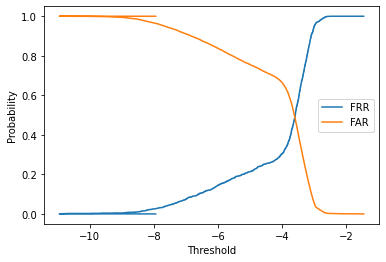

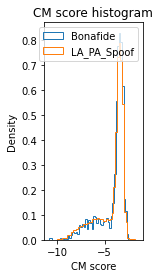

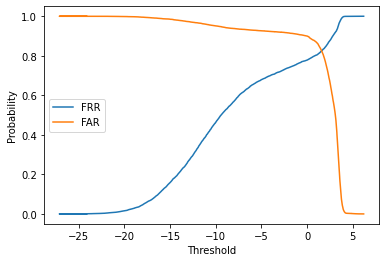

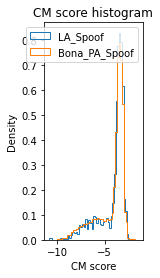

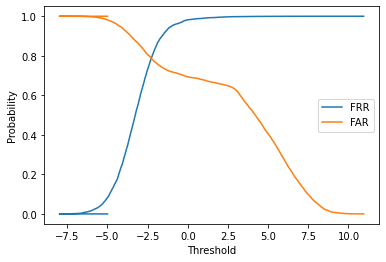

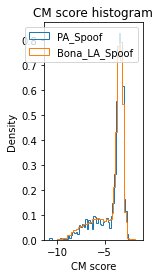

In [ ]:
def compute_det_curve(target_scores, nontarget_scores):

    n_scores = target_scores.size + nontarget_scores.size
    all_scores = np.concatenate((target_scores, nontarget_scores))
    labels = np.concatenate((np.ones(target_scores.size), np.zeros(nontarget_scores.size)))

    # Sort labels based on scores
    indices = np.argsort(all_scores, kind='mergesort')
    labels = labels[indices]

    # Compute false rejection and false acceptance rates
    tar_trial_sums = np.cumsum(labels)
    nontarget_trial_sums = nontarget_scores.size - (np.arange(1, n_scores + 1) - tar_trial_sums)

    frr = np.concatenate((np.atleast_1d(0), tar_trial_sums / target_scores.size))  # false rejection rates
    far = np.concatenate((np.atleast_1d(1), nontarget_trial_sums / nontarget_scores.size))  # false acceptance rates
    thresholds = np.concatenate((np.atleast_1d(all_scores[indices[0]] - 0.01 ), all_scores[indices]))  # Thresholds are the sorted scores

    return frr, far, thresholds


def compute_eer(target_scores, nontarget_scores):
    """ Returns equal error rate (EER) and the corresponding threshold. """
    frr, far, thresholds = compute_det_curve(target_scores, nontarget_scores)
    plt.figure()
    plt.plot(thresholds, frr, label='FRR')
    plt.plot(thresholds, far, label='FAR')
    plt.legend()
    plt.xlabel('Threshold')
    plt.ylabel('Probability')
    frr_mean = np.mean(frr)
    far_mean = np.mean(far)
    print('FAR: ', far_mean)
    print('FRR: ', frr_mean)
    abs_diffs = np.abs(frr - far)
    min_index = np.argmin(abs_diffs)
    eer = np.mean((frr[min_index], far[min_index]))
    return eer, thresholds[min_index]

cm_score_file = 'eval_output/eval_output.txt'
cm_data = np.genfromtxt(cm_score_file, dtype=str)
cm_utt_id = cm_data[:, 0]
cm_sources = cm_data[:, 1]
cm_keys = cm_data[:, 2]
cm_bona_scores = cm_data[:, 3].astype(np.float)
cm_LA_scores = cm_data[:, 4].astype(np.float)
cm_PA_scores = cm_data[:, 5].astype(np.float)

#bonafide
bona_cm = cm_bona_scores[cm_keys == 'bonafide']
spoof_cm = np.concatenate((cm_bona_scores[cm_keys == 'LA_spoof'], cm_bona_scores[cm_keys == 'PA_spoof']))

eer_cm = compute_eer(bona_cm, spoof_cm)[0]

plt.figure()
plt.subplot(131)
plt.hist(bona_cm, histtype='step', density=True, bins=50, label='Bonafide')
plt.hist(spoof_cm, histtype='step', density=True, bins=50, label='LA_PA_Spoof')
plt.legend()
plt.xlabel('CM score')
plt.ylabel('Density')
plt.title('CM score histogram')

print('   EER = {:8.9f} % (Equal error rate for countermeasure)'.format(eer_cm * 100))

#LA
LA_spoof_cm = cm_LA_scores[cm_keys == 'LA_spoof']
bona_PA_cm = np.concatenate((cm_LA_scores[cm_keys == 'bonafide'], cm_LA_scores[cm_keys == 'PA_spoof']))

eer_cm = compute_eer(LA_spoof_cm, bona_PA_cm)[0]

plt.figure()
plt.subplot(132)
plt.hist(bona_cm, histtype='step', density=True, bins=50, label='LA_Spoof')
plt.hist(spoof_cm, histtype='step', density=True, bins=50, label='Bona_PA_Spoof')
plt.legend()
plt.xlabel('CM score')
plt.ylabel('Density')
plt.title('CM score histogram')

print('   EER = {:8.9f} % (LA Equal error rate for countermeasure)'.format(eer_cm * 100))

#PA
PA_spoof_cm = cm_PA_scores[cm_keys == 'PA_spoof']
bona_LA_cm = np.concatenate((cm_PA_scores[cm_keys == 'bonafide'], cm_PA_scores[cm_keys == 'LA_spoof']))

eer_cm = compute_eer(PA_spoof_cm, bona_LA_cm)[0]

plt.figure()
plt.subplot(133)
plt.hist(bona_cm, histtype='step', density=True, bins=50, label='PA_Spoof')
plt.hist(spoof_cm, histtype='step', density=True, bins=50, label='Bona_LA_Spoof')
plt.legend()
plt.xlabel('CM score')
plt.ylabel('Density')
plt.title('CM score histogram')

print('   EER = {:8.9f} % (PA Equal error rate for countermeasure)'.format(eer_cm * 100))